In [2]:
#导入必要的第三方库
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import add, Conv2D,MaxPooling2D,UpSampling2D,Input,BatchNormalization, RepeatVector, Reshape
from keras.models import Model
np.random.seed(1)

In [3]:
InputPath="G:\BaiduNetdiskDownload\LOLdataset\our485\high"

# Noise Addition

In [4]:
def addNoise(image, salt_pepper_ratio=0.5, amount=0.004):
    # 复制图像以避免修改原始图像
    noiseAddedImage = np.copy(image)
    num_salt = np.ceil(amount * image.size * salt_pepper_ratio)
    num_pepper = np.ceil(amount * image.size * (1.0 - salt_pepper_ratio))

    # 添加盐噪声
    coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
    noiseAddedImage[coords[0], coords[1], :] = 1

    # 添加胡椒噪声
    coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
    noiseAddedImage[coords[0], coords[1], :] = 0

    return noiseAddedImage

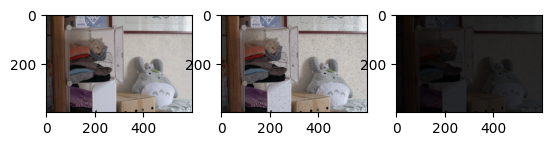

In [5]:
img = cv.imread(InputPath+"/21.png")
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
l = img.max()
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
Noise = addNoise(img)
plt.imshow(Noise)
plt.subplot(1,3,3)
hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV) #convert it to hsv
hsv[...,2] = hsv[...,2]*0.2
img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
Noise2 = addNoise(img1)
plt.imshow(Noise2)

# Data Preprocessing

In [6]:
from tqdm import tqdm
HighPath = r"G:\BaiduNetdiskDownload\LOLdataset\our485\high"

def preprocess_image(imagePath):
    low_img = cv.imread(imagePath)
    if low_img is None:
        print("Failed to load image: ", imagePath)
        return None, None
    low_img = cv.cvtColor(low_img, cv.COLOR_BGR2RGB)  # 从BGR转为RGB
    low_img = cv.resize(low_img, (500, 500))
    hsv = cv.cvtColor(low_img, cv.COLOR_RGB2HSV)  # 转换到HSV
    hsv[..., 2] = hsv[..., 2] * 0.2
    img_1 = cv.cvtColor(hsv, cv.COLOR_HSV2RGB)  # 将调整后的图像转回RGB
    Noisy_img = addNoise(img_1)
    return Noisy_img, low_img

def batch_generator(ImagePath, batch_size=10):
    file_names = os.listdir(ImagePath)
    for i in tqdm(range(0, len(file_names), batch_size)):
        X_, y_ = [], []
        for file_name in file_names[i:i + batch_size]:
            imagePath = os.path.join(ImagePath, file_name)
            Noisy_img, low_img = preprocess_image(imagePath)
            if Noisy_img is None or low_img is None:  # 图像加载失败的情况
                continue
            X_.append(Noisy_img)
            y_.append(low_img)
        yield np.array(X_), np.array(y_)
for X_batch, y_batch in batch_generator(HighPath, batch_size=10):
     pass

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:05<00:00,  8.18it/s]


# Model Creation

In [6]:
import tensorflow as tf
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
# 清除之前的模型
K.clear_session()
# 定义模型函数
def InstantiateModel(in_):
    model_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_1)
    model_1 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_1)

    model_2 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(in_)
    model_2 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_2_0 = Conv2D(64,(2,2), activation='relu',padding='same',strides=1)(model_2)

    model_add = add([model_1,model_2,model_2_0])

    model_3 = Conv2D(64,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_3)
    model_3 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3)

    model_3_1 = Conv2D(32,(3,3), activation='relu',padding='same',strides=1)(model_add)
    model_3_1 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_3_1)

    model_3_2 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add)

    model_add_2 = add([model_3_1,model_3_2,model_3])

    model_4 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_2)
    model_4_1 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add)

    model_add_3 = add([model_4_1,model_add_2,model_4])

    model_5 = Conv2D(16,(3,3), activation='relu',padding='same',strides=1)(model_add_3)
    model_5 = Conv2D(16,(2,2), activation='relu',padding='same',strides=1)(model_add_3)

    model_5 = Conv2D(3,(3,3), activation='relu',padding='same',strides=1)(model_5)
    return model_5
# 创建模型的输入层
Input_Sample = Input(shape=(500, 500,3))

# 调用定义的模型函数创建模型
Output_ = InstantiateModel(Input_Sample)

# 创建 Keras 模型
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)

# 编译模型
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')

# 打印模型概况
Model_Enhancer.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 500, 500, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 500, 500, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 500, 500, 32)      │             896 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 500, 500, 32)      │           4,640 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 500, 500, 64)      │           8,256 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 500, 500, 64)      │           8,256 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 500, 500, 64)      │          16,448 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 500, 500, 64)      │               0 │ conv2d_2[0][0],            │
│                               │                           │                 │ conv2d_4[0][0],            │
│                               │                           │                 │ conv2d_5[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 500, 500, 64)      │          36,928 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_9 (Conv2D)             │ (None, 500, 500, 32)      │          18,464 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 500, 500, 32)      │          18,464 │ conv2d_6[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_10 (Conv2D)            │ (None, 500, 500, 16)      │           2,064 │ conv2d_9[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_11 (Conv2D)            │ (None, 500, 500, 16)      │           4,112 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 500, 500, 16)      │           2,064 │ conv2d_7[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 500, 500, 16)      │               0 │ conv2d_10[0][0],           │
│                               │                           │                 │ conv2d_11[0][0],           │
│                               │                           │                 │ conv2d_8[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 134,067 (523.70 KB)

 Trainable params: 134,067 (523.70 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#SVG(model_to_dot(Model_Enhancer, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [7]:
Input_Sample = Input(shape=(500, 500,3))
Output_ = InstantiateModel(Input_Sample)
Model_Enhancer = Model(inputs=Input_Sample, outputs=Output_)
Model_Enhancer.compile(optimizer="adam", loss='mean_squared_error')
Model_Enhancer.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 500, 500, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_17 (Conv2D)            │ (None, 500, 500, 16)      │             448 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_20 (Conv2D)            │ (None, 500, 500, 32)      │             896 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_18 (Conv2D)            │ (None, 500, 500, 32)      │           4,640 │ conv2d_17[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_21 (Conv2D)            │ (None, 500, 500, 64)      │           8,256 │ conv2d_20[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_19 (Conv2D)            │ (None, 500, 500, 64)      │           8,256 │ conv2d_18[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_22 (Conv2D)            │ (None, 500, 500, 64)      │          16,448 │ conv2d_21[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_3 (Add)                   │ (None, 500, 500, 64)      │               0 │ conv2d_19[0][0],           │
│                               │                           │                 │ conv2d_21[0][0],           │
│                               │                           │                 │ conv2d_22[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_23 (Conv2D)            │ (None, 500, 500, 64)      │          36,928 │ add_3[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_26 (Conv2D)            │ (None, 500, 500, 32)      │          18,464 │ add_3[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_24 (Conv2D)            │ (None, 500, 500, 32)      │          18,464 │ conv2d_23[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_27 (Conv2D)            │ (None, 500, 500, 16)      │           2,064 │ conv2d_26[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_28 (Conv2D)            │ (None, 500, 500, 16)      │           4,112 │ add_3[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_25 (Conv2D)            │ (None, 500, 500, 16)      │           2,064 │ conv2d_24[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_4 (Add)                   │ (None, 500, 500, 16)      │               0 │ conv2d_27[0][0],           │
│                               │                           │                 │ conv2d_28[0][0],           │
│                               │                           │                 │ conv2d_25[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 134,067 (523.70 KB)

 Trainable params: 134,067 (523.70 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#from tensorflow.keras.utils import plot_model
#plot_model(Model_Enhancer,to_file='model_.png',show_shapes=True, show_layer_names=True)
#from IPython.display import Image
#Image(retina=True, filename='model_.png')

# Training

In [8]:
#def GenerateInputs(X,y):
#    for i in range(len(X)):
#        X_input = X[i].reshape(1,500,500,3)
#        y_input = y[i].reshape(1,500,500,3)
 #       yield (X_input,y_input)
#Model_Enhancer.fit(batch_generator(HighPath, batch_size=10), epochs=49, verbose=1, steps_per_epoch=1, shuffle=True) #epochs * steps_per_epoch <= training dataset images...

  2%|█▋                                                                                 | 1/49 [00:00<00:05,  8.19it/s]

Epoch 1/49
1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step - loss: 13762.4814
Epoch 2/49


  4%|███▍                                                                               | 2/49 [00:18<08:21, 10.68s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 8684.8115
Epoch 3/49


  6%|█████                                                                              | 3/49 [00:32<09:24, 12.27s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step - loss: 12666.1016
Epoch 4/49


  8%|██████▊                                                                            | 4/49 [00:46<09:37, 12.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 8165.4497
Epoch 5/49


 10%|████████▍                                                                          | 5/49 [00:59<09:28, 12.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 7481.9209
Epoch 6/49


 12%|██████████▏                                                                        | 6/49 [01:12<09:17, 12.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 6663.8574
Epoch 7/49


 14%|███████████▊                                                                       | 7/49 [01:25<09:04, 12.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 5908.6963
Epoch 8/49


 16%|█████████████▌                                                                     | 8/49 [01:38<08:52, 12.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 5296.1675
Epoch 9/49


 18%|███████████████▏                                                                   | 9/49 [01:51<08:38, 12.96s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 4061.6047
Epoch 10/49


 20%|████████████████▋                                                                 | 10/49 [02:04<08:26, 12.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 4661.4165
Epoch 11/49


 22%|██████████████████▍                                                               | 11/49 [02:17<08:14, 13.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 3166.7278
Epoch 12/49


 24%|████████████████████                                                              | 12/49 [02:30<08:01, 13.01s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 2337.3110
Epoch 13/49


 27%|█████████████████████▊                                                            | 13/49 [02:43<07:47, 13.00s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 1226.1281
Epoch 14/49


 29%|███████████████████████▍                                                          | 14/49 [02:55<07:32, 12.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 890.9084
Epoch 15/49


 31%|█████████████████████████                                                         | 15/49 [03:08<07:18, 12.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 596.6210
Epoch 16/49


 33%|██████████████████████████▊                                                       | 16/49 [03:21<07:04, 12.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 732.6240
Epoch 17/49


 35%|████████████████████████████▍                                                     | 17/49 [03:34<06:53, 12.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 610.3996
Epoch 18/49


 37%|██████████████████████████████                                                    | 18/49 [03:47<06:40, 12.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 663.0085
Epoch 19/49


 39%|███████████████████████████████▊                                                  | 19/49 [04:00<06:27, 12.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 818.1890
Epoch 20/49


 41%|█████████████████████████████████▍                                                | 20/49 [04:13<06:13, 12.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 840.7300
Epoch 21/49


 43%|███████████████████████████████████▏                                              | 21/49 [04:26<06:00, 12.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 684.0034
Epoch 22/49


 45%|████████████████████████████████████▊                                             | 22/49 [04:39<05:48, 12.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 902.8519
Epoch 23/49


 47%|██████████████████████████████████████▍                                           | 23/49 [04:51<05:35, 12.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 966.7947
Epoch 24/49


 49%|████████████████████████████████████████▏                                         | 24/49 [05:04<05:22, 12.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 760.9692
Epoch 25/49


 51%|█████████████████████████████████████████▊                                        | 25/49 [05:17<05:09, 12.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 573.4818
Epoch 26/49


 53%|███████████████████████████████████████████▌                                      | 26/49 [05:30<04:57, 12.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 598.8491
Epoch 27/49


 55%|█████████████████████████████████████████████▏                                    | 27/49 [05:43<04:43, 12.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 571.0279
Epoch 28/49


 57%|██████████████████████████████████████████████▊                                   | 28/49 [05:56<04:29, 12.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 510.2913
Epoch 29/49


 59%|████████████████████████████████████████████████▌                                 | 29/49 [06:09<04:17, 12.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 454.2690
Epoch 30/49


 61%|██████████████████████████████████████████████████▏                               | 30/49 [06:21<04:04, 12.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 419.0835
Epoch 31/49


 63%|███████████████████████████████████████████████████▉                              | 31/49 [06:34<03:51, 12.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 280.5699
Epoch 32/49


 65%|█████████████████████████████████████████████████████▌                            | 32/49 [06:47<03:37, 12.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 354.9199
Epoch 33/49


 67%|███████████████████████████████████████████████████████▏                          | 33/49 [07:00<03:25, 12.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 335.6836
Epoch 34/49


 69%|████████████████████████████████████████████████████████▉                         | 34/49 [07:13<03:12, 12.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 261.5883
Epoch 35/49


 71%|██████████████████████████████████████████████████████████▌                       | 35/49 [07:26<02:59, 12.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 230.4964
Epoch 36/49


 73%|████████████████████████████████████████████████████████████▏                     | 36/49 [07:38<02:47, 12.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 379.6083
Epoch 37/49


 76%|█████████████████████████████████████████████████████████████▉                    | 37/49 [07:51<02:34, 12.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 388.0412
Epoch 38/49


 78%|███████████████████████████████████████████████████████████████▌                  | 38/49 [08:04<02:21, 12.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 205.1719
Epoch 39/49


 80%|█████████████████████████████████████████████████████████████████▎                | 39/49 [08:17<02:09, 12.97s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 220.8225
Epoch 40/49


 82%|██████████████████████████████████████████████████████████████████▉               | 40/49 [08:30<01:56, 12.99s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 167.1477
Epoch 41/49


 84%|████████████████████████████████████████████████████████████████████▌             | 41/49 [08:43<01:43, 12.93s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 159.3934
Epoch 42/49


 86%|██████████████████████████████████████████████████████████████████████▎           | 42/49 [08:56<01:30, 12.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 154.3731
Epoch 43/49


 88%|███████████████████████████████████████████████████████████████████████▉          | 43/49 [09:09<01:17, 12.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 307.6295
Epoch 44/49


 90%|█████████████████████████████████████████████████████████████████████████▋        | 44/49 [09:22<01:04, 12.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 270.4430
Epoch 45/49


 92%|███████████████████████████████████████████████████████████████████████████▎      | 45/49 [09:35<00:51, 12.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 177.2326
Epoch 46/49


 94%|████████████████████████████████████████████████████████████████████████████▉     | 46/49 [09:47<00:38, 12.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 265.5592
Epoch 47/49


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 47/49 [10:00<00:25, 12.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 192.4504
Epoch 48/49


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 48/49 [10:13<00:12, 12.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 187.0075
Epoch 49/49


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [10:26<00:00, 12.78s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 334.1197


In [9]:
TestPath="G:\BaiduNetdiskDownload\LOLdataset\our485\high"

In [19]:
HighPath = r"G:\BaiduNetdiskDownload\LOLdataset\our485\high"
batch_size = 10
epochs = 49
steps_per_epoch = 1  # 你可以根据数据集的大小调整这个值

# 使用数据生成器开始训练模型，并获取训练历史数据
history = Model_Enhancer.fit(
    batch_generator(HighPath, batch_size=batch_size),
    epochs=epochs,
    verbose=1,
    steps_per_epoch=steps_per_epoch,
    shuffle=True
)

# 提取训练过程中的损失值
training_loss = history.history['loss']

# 输出每次epoch的损失值
print("Training Loss for each epoch:")
for epoch, loss in enumerate(training_loss):
    print(f"Epoch {epoch + 1}: {loss}")

# 也可以只输出最终的损失值
final_loss = training_loss[-1]
print(f"Final Training Loss: {final_loss}")

  2%|█▋                                                                                 | 1/49 [00:00<00:04,  9.80it/s]

Epoch 1/49
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 244.3637
Epoch 2/49


  4%|███▍                                                                               | 2/49 [00:13<06:16,  8.02s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 224.2545
Epoch 3/49


  6%|█████                                                                              | 3/49 [00:26<08:00, 10.44s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 251.6891
Epoch 4/49


  8%|██████▊                                                                            | 4/49 [00:40<08:37, 11.49s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 262.1100
Epoch 5/49


 10%|████████▍                                                                          | 5/49 [00:53<08:52, 12.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 272.2792
Epoch 6/49


 12%|██████████▏                                                                        | 6/49 [01:06<08:58, 12.52s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 209.2264
Epoch 7/49


 14%|███████████▊                                                                       | 7/49 [01:19<08:53, 12.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 97.0476
Epoch 8/49


 16%|█████████████▌                                                                     | 8/49 [01:32<08:45, 12.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 139.3932
Epoch 9/49


 18%|███████████████▏                                                                   | 9/49 [01:45<08:33, 12.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 145.1506
Epoch 10/49


 20%|████████████████▋                                                                 | 10/49 [01:58<08:22, 12.87s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 134.3007
Epoch 11/49


 22%|██████████████████▍                                                               | 11/49 [02:11<08:09, 12.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 169.2433
Epoch 12/49


 24%|████████████████████                                                              | 12/49 [02:24<07:56, 12.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 193.1171
Epoch 13/49


 27%|█████████████████████▊                                                            | 13/49 [02:37<07:42, 12.85s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 107.6706
Epoch 14/49


 29%|███████████████████████▍                                                          | 14/49 [02:49<07:29, 12.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 227.3865
Epoch 15/49


 31%|█████████████████████████                                                         | 15/49 [03:02<07:14, 12.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 229.4569
Epoch 16/49


 33%|██████████████████████████▊                                                       | 16/49 [03:15<07:01, 12.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 251.0182
Epoch 17/49


 35%|████████████████████████████▍                                                     | 17/49 [03:28<06:49, 12.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 310.6469
Epoch 18/49


 37%|██████████████████████████████                                                    | 18/49 [03:40<06:36, 12.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 335.2879
Epoch 19/49


 39%|███████████████████████████████▊                                                  | 19/49 [03:53<06:22, 12.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 369.3016
Epoch 20/49


 41%|█████████████████████████████████▍                                                | 20/49 [04:06<06:10, 12.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 415.7781
Epoch 21/49


 43%|███████████████████████████████████▏                                              | 21/49 [04:19<05:57, 12.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 346.7865
Epoch 22/49


 45%|████████████████████████████████████▊                                             | 22/49 [04:32<05:45, 12.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 349.6658
Epoch 23/49


 47%|██████████████████████████████████████▍                                           | 23/49 [04:44<05:32, 12.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 213.6247
Epoch 24/49


 49%|████████████████████████████████████████▏                                         | 24/49 [04:57<05:18, 12.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 145.4951
Epoch 25/49


 51%|█████████████████████████████████████████▊                                        | 25/49 [05:10<05:05, 12.71s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 80.8897
Epoch 26/49


 53%|███████████████████████████████████████████▌                                      | 26/49 [05:22<04:53, 12.74s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 170.9727
Epoch 27/49


 55%|█████████████████████████████████████████████▏                                    | 27/49 [05:35<04:40, 12.76s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 92.7951
Epoch 28/49


 57%|██████████████████████████████████████████████▊                                   | 28/49 [05:48<04:28, 12.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 121.5763
Epoch 29/49


 59%|████████████████████████████████████████████████▌                                 | 29/49 [06:01<04:18, 12.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 92.3663
Epoch 30/49


 61%|██████████████████████████████████████████████████▏                               | 30/49 [06:14<04:04, 12.89s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 161.0588
Epoch 31/49


 63%|███████████████████████████████████████████████████▉                              | 31/49 [06:27<03:53, 12.95s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 105.6379
Epoch 32/49


 65%|█████████████████████████████████████████████████████▌                            | 32/49 [06:40<03:39, 12.91s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 143.7253
Epoch 33/49


 67%|███████████████████████████████████████████████████████▏                          | 33/49 [06:53<03:26, 12.90s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 141.5439
Epoch 34/49


 69%|████████████████████████████████████████████████████████▉                         | 34/49 [07:06<03:13, 12.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 103.6304
Epoch 35/49


 71%|██████████████████████████████████████████████████████████▌                       | 35/49 [07:19<02:59, 12.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 110.7009
Epoch 36/49


 73%|████████████████████████████████████████████████████████████▏                     | 36/49 [07:31<02:46, 12.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 206.3805
Epoch 37/49


 76%|█████████████████████████████████████████████████████████████▉                    | 37/49 [07:44<02:34, 12.84s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 217.7660
Epoch 38/49


 78%|███████████████████████████████████████████████████████████████▌                  | 38/49 [07:57<02:21, 12.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 126.5774
Epoch 39/49


 80%|█████████████████████████████████████████████████████████████████▎                | 39/49 [08:10<02:07, 12.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 98.6888
Epoch 40/49


 82%|██████████████████████████████████████████████████████████████████▉               | 40/49 [08:22<01:55, 12.78s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 91.6155
Epoch 41/49


 84%|████████████████████████████████████████████████████████████████████▌             | 41/49 [08:35<01:42, 12.83s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 101.7870
Epoch 42/49


 86%|██████████████████████████████████████████████████████████████████████▎           | 42/49 [08:48<01:29, 12.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 75.7711
Epoch 43/49


 88%|███████████████████████████████████████████████████████████████████████▉          | 43/49 [09:01<01:16, 12.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 129.0359
Epoch 44/49


 90%|█████████████████████████████████████████████████████████████████████████▋        | 44/49 [09:14<01:04, 12.80s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 106.7984
Epoch 45/49


 92%|███████████████████████████████████████████████████████████████████████████▎      | 45/49 [09:27<00:51, 12.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 104.9527
Epoch 46/49


 94%|████████████████████████████████████████████████████████████████████████████▉     | 46/49 [09:39<00:38, 12.81s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 133.7451
Epoch 47/49


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 47/49 [09:52<00:25, 12.79s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 101.8358
Epoch 48/49


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 48/49 [10:05<00:12, 12.82s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - loss: 66.0277
Epoch 49/49


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [10:18<00:00, 12.62s/it]


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 182.7024
Training Loss for each epoch:
Epoch 1: 244.3637237548828
Epoch 2: 224.2545166015625
Epoch 3: 251.6891326904297
Epoch 4: 262.1099548339844
Epoch 5: 272.2791748046875
Epoch 6: 209.22637939453125
Epoch 7: 97.04762268066406
Epoch 8: 139.39321899414062
Epoch 9: 145.15057373046875
Epoch 10: 134.3007049560547
Epoch 11: 169.2432861328125
Epoch 12: 193.1170654296875
Epoch 13: 107.67061614990234
Epoch 14: 227.38648986816406
Epoch 15: 229.45693969726562
Epoch 16: 251.01821899414062
Epoch 17: 310.6468811035156
Epoch 18: 335.28790283203125
Epoch 19: 369.3016357421875
Epoch 20: 415.7781066894531
Epoch 21: 346.7864685058594
Epoch 22: 349.6658020019531
Epoch 23: 213.6246795654297
Epoch 24: 145.4950714111328
Epoch 25: 80.88968658447266
Epoch 26: 170.97265625
Epoch 27: 92.7951431274414
Epoch 28: 121.57634735107422
Epoch 29: 92.36634063720703
Epoch 30: 161.05877685546875
Epoch 31: 105.63787841796875
Epoch 32: 143.72528076171875
Epoch 33: 141.5438995361

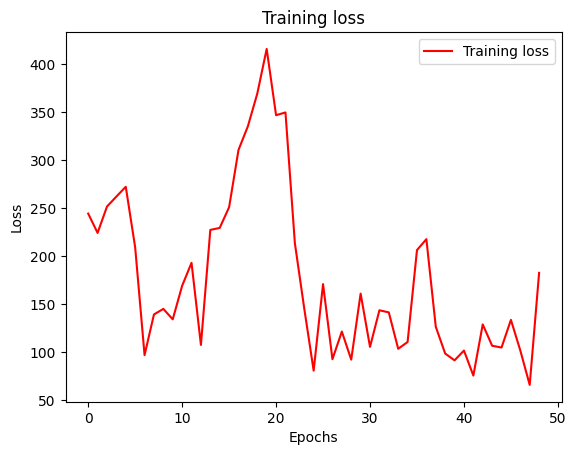

In [20]:
import matplotlib.pyplot as plt

# 获取训练损失
train_loss = history.history['loss']

# 绘制损失曲线
epochs = range(len(train_loss))
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
from tensorflow.keras.layers import Conv2D, Input, add
from tensorflow.keras.models import Model

def InstantiateModel_v2(in_):
    model_1 = Conv2D(8, (3, 3), activation='relu', padding='same', strides=1)(in_)
    model_1 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(model_1)
    
    model_2 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(in_)
    
    model_add = add([model_1, model_2])
    
    model_3 = Conv2D(32, (3, 3), activation='relu', padding='same', strides=1)(model_add)
    model_3 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(model_3)
    
    model_3_1 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(model_add)

    model_add_2 = add([model_3_1, model_3])
    
    model_4 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(model_add_2)
    
    model_add_3 = add([model_4, model_add_2])
    
    model_5 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(model_add_3)

    model_5 = Conv2D(3, (3, 3), activation='linear', padding='same', strides=1)(model_5)
    
    return model_5

# 创建模型的输入层
Input_Sample_v2 = Input(shape=(500, 500, 3))

# 调用定义的模型函数创建模型
Output_v2 = InstantiateModel_v2(Input_Sample_v2)

# 创建 Keras 模型
Model_Enhancer_v2 = Model(inputs=Input_Sample_v2, outputs=Output_v2)

# 编译模型
Model_Enhancer_v2.compile(optimizer="adam", loss='mean_squared_error')

# 输出模型的结构
Model_Enhancer_v2.summary()

# 训练新的模型
history_new = Model_Enhancer_v2.fit(
    batch_generator(HighPath, batch_size=10),
    epochs=49,
    verbose=1,
    steps_per_epoch=1,
    shuffle=True
)

# 提取训练过程中的损失值
training_loss_new = history_new.history['loss']

# 输出每次epoch的损失值
print("New Training Loss for each epoch:")
for epoch, loss in enumerate(training_loss_new):
    print(f"Epoch {epoch + 1}: {loss}")

# 也可以只输出最终的损失值
final_loss_new = training_loss_new[-1]
print(f"Final Training Loss: {final_loss_new}")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 500, 500, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 500, 500, 8)       │             224 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 500, 500, 16)      │           1,168 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 500, 500, 16)      │             448 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 500, 500, 16)      │               0 │ conv2d_1[0][0],            │
│                               │                           │                 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 500, 500, 32)      │           4,640 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 500, 500, 16)      │           2,320 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 500, 500, 16)      │           4,624 │ conv2d_3[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 500, 500, 16)      │               0 │ conv2d_5[0][0],            │
│                               │                           │                 │ conv2d_4[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_6 (Conv2D)             │ (None, 500, 500, 16)      │           2,320 │ add_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 500, 500, 16)      │               0 │ conv2d_6[0][0],            │
│                               │                           │                 │ add_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_7 (Conv2D)             │ (None, 500, 500, 16)      │           2,320 │ add_2[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_8 (Conv2D)             │ (None, 500, 500, 3)       │             435 │ conv2d_7[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 18,499 (72.26 KB)

 Trainable params: 18,499 (72.26 KB)

 Non-trainable params: 0 (0.00 B)

  0%|                                                                                           | 0/49 [00:00<?, ?it/s]

Epoch 1/49
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 20674.6133
Epoch 2/49


  4%|███▍                                                                               | 2/49 [00:02<00:56,  1.20s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 720ms/step - loss: 17531.8809
Epoch 3/49


  6%|█████                                                                              | 3/49 [00:03<00:45,  1.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 737ms/step - loss: 18438.1055
Epoch 4/49


  8%|██████▊                                                                            | 4/49 [00:03<00:40,  1.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step - loss: 15515.4658
Epoch 5/49


 10%|████████▍                                                                          | 5/49 [00:04<00:37,  1.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step - loss: 13473.4131
Epoch 6/49


 12%|██████████▏                                                                        | 6/49 [00:05<00:34,  1.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step - loss: 9354.4023
Epoch 7/49


 14%|███████████▊                                                                       | 7/49 [00:06<00:33,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step - loss: 7506.3486
Epoch 8/49


 16%|█████████████▌                                                                     | 8/49 [00:06<00:31,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step - loss: 6051.2305
Epoch 9/49


 18%|███████████████▏                                                                   | 9/49 [00:07<00:30,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step - loss: 3775.6575
Epoch 10/49


 20%|████████████████▋                                                                 | 10/49 [00:08<00:29,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 739ms/step - loss: 3058.4807
Epoch 11/49


 22%|██████████████████▍                                                               | 11/49 [00:09<00:28,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 742ms/step - loss: 2850.3704
Epoch 12/49


 24%|████████████████████                                                              | 12/49 [00:09<00:27,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step - loss: 4169.7725
Epoch 13/49


 27%|█████████████████████▊                                                            | 13/49 [00:10<00:26,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step - loss: 3947.1292
Epoch 14/49


 29%|███████████████████████▍                                                          | 14/49 [00:11<00:25,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step - loss: 2402.1731
Epoch 15/49


 31%|█████████████████████████                                                         | 15/49 [00:11<00:25,  1.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step - loss: 2027.8350
Epoch 16/49


 33%|██████████████████████████▊                                                       | 16/49 [00:12<00:24,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step - loss: 1595.0314
Epoch 17/49


 35%|████████████████████████████▍                                                     | 17/49 [00:13<00:23,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step - loss: 920.9616
Epoch 18/49


 37%|██████████████████████████████                                                    | 18/49 [00:14<00:23,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step - loss: 858.8758
Epoch 19/49


 39%|███████████████████████████████▊                                                  | 19/49 [00:14<00:22,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step - loss: 924.0330
Epoch 20/49


 41%|█████████████████████████████████▍                                                | 20/49 [00:15<00:21,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step - loss: 1043.6371
Epoch 21/49


 43%|███████████████████████████████████▏                                              | 21/49 [00:16<00:20,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step - loss: 856.9342
Epoch 22/49


 45%|████████████████████████████████████▊                                             | 22/49 [00:17<00:20,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step - loss: 1002.0941
Epoch 23/49


 47%|██████████████████████████████████████▍                                           | 23/49 [00:17<00:19,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step - loss: 902.1671
Epoch 24/49


 49%|████████████████████████████████████████▏                                         | 24/49 [00:18<00:18,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step - loss: 508.8492
Epoch 25/49


 51%|█████████████████████████████████████████▊                                        | 25/49 [00:19<00:18,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 743ms/step - loss: 237.8061
Epoch 26/49


 53%|███████████████████████████████████████████▌                                      | 26/49 [00:20<00:17,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step - loss: 323.8269
Epoch 27/49


 55%|█████████████████████████████████████████████▏                                    | 27/49 [00:21<00:16,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step - loss: 325.5414
Epoch 28/49


 57%|██████████████████████████████████████████████▊                                   | 28/49 [00:21<00:16,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 824ms/step - loss: 382.3885
Epoch 29/49


 59%|████████████████████████████████████████████████▌                                 | 29/49 [00:22<00:15,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step - loss: 366.5811
Epoch 30/49


 61%|██████████████████████████████████████████████████▏                               | 30/49 [00:23<00:14,  1.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step - loss: 548.0709
Epoch 31/49


 63%|███████████████████████████████████████████████████▉                              | 31/49 [00:24<00:14,  1.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 763ms/step - loss: 349.1482
Epoch 32/49


 65%|█████████████████████████████████████████████████████▌                            | 32/49 [00:24<00:13,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step - loss: 403.5009
Epoch 33/49


 67%|███████████████████████████████████████████████████████▏                          | 33/49 [00:25<00:12,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step - loss: 423.5975
Epoch 34/49


 69%|████████████████████████████████████████████████████████▉                         | 34/49 [00:26<00:11,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step - loss: 349.7522
Epoch 35/49


 71%|██████████████████████████████████████████████████████████▌                       | 35/49 [00:27<00:10,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step - loss: 388.3598
Epoch 36/49


 73%|████████████████████████████████████████████████████████████▏                     | 36/49 [00:27<00:09,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step - loss: 542.6700
Epoch 37/49


 76%|█████████████████████████████████████████████████████████████▉                    | 37/49 [00:28<00:09,  1.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step - loss: 576.3939
Epoch 38/49


 78%|███████████████████████████████████████████████████████████████▌                  | 38/49 [00:29<00:08,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step - loss: 339.4210
Epoch 39/49


 80%|█████████████████████████████████████████████████████████████████▎                | 39/49 [00:30<00:07,  1.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step - loss: 407.5180
Epoch 40/49


 82%|██████████████████████████████████████████████████████████████████▉               | 40/49 [00:30<00:06,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 734ms/step - loss: 278.7102
Epoch 41/49


 84%|████████████████████████████████████████████████████████████████████▌             | 41/49 [00:31<00:05,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step - loss: 203.3166
Epoch 42/49


 86%|██████████████████████████████████████████████████████████████████████▎           | 42/49 [00:32<00:05,  1.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 732ms/step - loss: 221.3500
Epoch 43/49


 88%|███████████████████████████████████████████████████████████████████████▉          | 43/49 [00:33<00:04,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 754ms/step - loss: 356.3479
Epoch 44/49


 90%|█████████████████████████████████████████████████████████████████████████▋        | 44/49 [00:33<00:03,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step - loss: 325.2161
Epoch 45/49


 92%|███████████████████████████████████████████████████████████████████████████▎      | 45/49 [00:34<00:02,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step - loss: 303.0231
Epoch 46/49


 94%|████████████████████████████████████████████████████████████████████████████▉     | 46/49 [00:35<00:02,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 750ms/step - loss: 358.9693
Epoch 47/49


 96%|██████████████████████████████████████████████████████████████████████████████▋   | 47/49 [00:36<00:01,  1.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 731ms/step - loss: 237.4369
Epoch 48/49


 98%|████████████████████████████████████████████████████████████████████████████████▎ | 48/49 [00:36<00:00,  1.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 736ms/step - loss: 202.8333
Epoch 49/49


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [00:37<00:00,  1.30it/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - loss: 403.1306
New Training Loss for each epoch:
Epoch 1: 20674.61328125
Epoch 2: 17531.880859375
Epoch 3: 18438.10546875
Epoch 4: 15515.4658203125
Epoch 5: 13473.4130859375
Epoch 6: 9354.40234375
Epoch 7: 7506.3486328125
Epoch 8: 6051.23046875
Epoch 9: 3775.657470703125
Epoch 10: 3058.480712890625
Epoch 11: 2850.370361328125
Epoch 12: 4169.7724609375
Epoch 13: 3947.129150390625
Epoch 14: 2402.173095703125
Epoch 15: 2027.8349609375
Epoch 16: 1595.0313720703125
Epoch 17: 920.9616088867188
Epoch 18: 858.8757934570312
Epoch 19: 924.0330200195312
Epoch 20: 1043.6370849609375
Epoch 21: 856.9342041015625
Epoch 22: 1002.0940551757812
Epoch 23: 902.1670532226562
Epoch 24: 508.8492126464844
Epoch 25: 237.8061065673828
Epoch 26: 323.826904296875
Epoch 27: 325.5414123535156
Epoch 28: 382.3884582519531
Epoch 29: 366.5810546875
Epoch 30: 548.0709228515625
Epoch 31: 349.1482238769531
Epoch 32: 403.5009460449219
Epoch 33: 423.5975036621094
Epoch 34: 349.752166

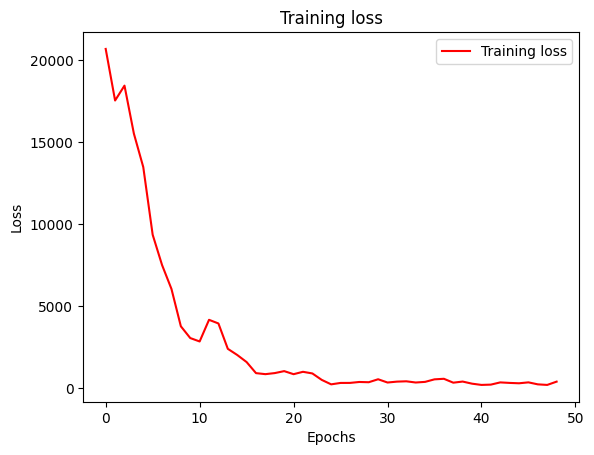

In [8]:
import matplotlib.pyplot as plt

# 获取训练损失
train_loss = history_new.history['loss']

# 绘制损失曲线
epochs = range(len(train_loss))
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
def ExtractTestInput(ImagePath):
    img = cv.imread(ImagePath)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img_ = cv.resize(img, (500, 500))
    hsv = cv.cvtColor(img_, cv.COLOR_BGR2HSV)  # convert it to hsv
    hsv[..., 2] = hsv[..., 2]*0.2
    img1 = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    Noise = addNoise(img1)
    Noise = Noise.reshape(1, 500, 500, 3)
    return Noise

# Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


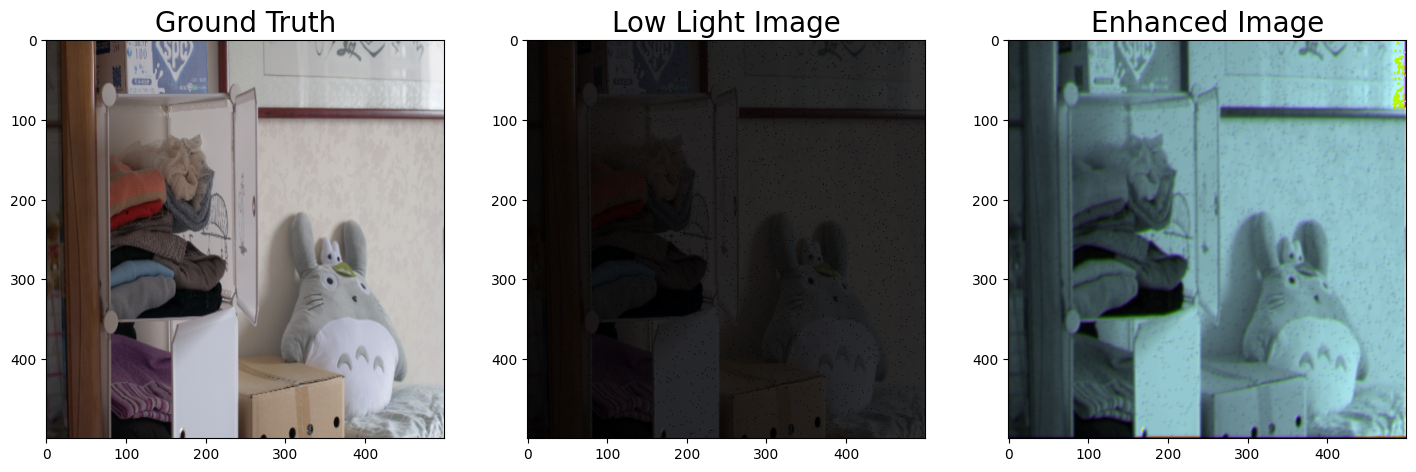

In [11]:
ImagePath=TestPath+"/21.png"

plt.figure(figsize=(30,30))
plt.subplot(5,5,1)
img_1 = cv.imread(ImagePath)
img_1 = cv.cvtColor(img_1, cv.COLOR_BGR2RGB)
img_1 = cv.resize(img_1, (500, 500))
plt.title("Ground Truth",fontsize=20)
plt.imshow(img_1)

plt.subplot(5,5,1+1)
img_ = ExtractTestInput(ImagePath)
img_ = img_.reshape(500,500,3)
plt.title("Low Light Image",fontsize=20)
plt.imshow(img_)

plt.subplot(5,5,1+2)
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Enhancer.predict(image_for_test)
Prediction = Prediction.reshape(500,500,3)
img_[:,:,:] = Prediction[:,:,:]
plt.title("Enhanced Image",fontsize=20)
plt.imshow(img_)
